# RICA: Reconstruction Independent Component Analysis

# Generate Zeta Fields

<b>Import modules
AND BLAH BLAH</b>


In [1]:
# %load_ext autoreload

In [14]:
import importlib as il
import copy

from pathlib import Path # For path manipulations and module loading
import numpy as np
import matplotlib.pyplot as plt # plt.rcParams.update({'font.size': 12})
# import matplotlib.gridspec as grd
import pickle

import scipy.interpolate as interpolate
import scipy.signal as signal
import scipy.stats as stats
from scipy.signal.windows import hann

# Independent Component Analysis
# sklearn module contains contains a FastICA capability. We can chose the cost function (measure of non-Gaussianity): 
# cube for kurtosis and logcosh for negentropy approximation.
from sklearn.decomposition import FastICA

# import nbodykit.lab as nbkt
import modules.jaafar_peaks as px
import modules.jaafar_fouriertransform as ft
import modules.jaafar_correlationfunctions as cf

import modules.fields_gauss as grf
import modules.fields_nong as nong
import modules.filters as flt
import modules.ica as ica
import modules.helpers as helper
from modules.helpers import resid

zeta multiplication factor = { (2*\pi*sidelength)/(sidelength_in_mpc) }^3

peak-patch/tools/powerspectrum_create

pkp/tables/planck18_intermittent.dat
(1st column -- k; 2nd -- delta_delta power spectrum; 3rd -- zeta transfer func/k^2)
zeta power spectrum = 2nd col / 3rd^2

tables/plot_spectra.py line 142

zeta = zeta(g)

take flat GRF power spectrum, multiply by sqrt[ (2*\pi*N / N_in_Mpc)^3 {power spectra above} ].

will have real-space zeta(x) = zeta_g + fnl*chi^2

Hann Window: 

w(n) = 0.5 - 0.5 * cos( (2 * pi * n) / (M-1) )     

[0 <= n <= M - 1]

## Generate Primodial $\zeta$ Fields

### Gaussian Random Fields:
<b>Set parameters and initialize the $\zeta$ GRFs.</b>

In [15]:
def grf_ensemble(N_ensemble, N_field, A0=7.96*10**-10, ns=1.0, kmnr=2/3, ensemble_seeds=None):
    """

    """

    ensemble = np.zeros((N_ensemble, N_field))
    N = N_field

    # if ensemble_seeds is None:
    #     seeds = np.zeros(N_ensemble)
    #     for i in range(N_ensemble):
    #         seeds[i] = np.random.get_state()
    # else:
    #     seeds = ensemble_seeds

    for i in range(N_ensemble):
        # np.random.set_state(seeds[i])
        # zg = grf.grf_zeta_1d(N, pk_amp=A0, pk_ns=ns, kmaxknyq_ratio=kmnr, seed=seeds[i])
        
        zg = grf.grf_zeta_1d(N, pk_amp=A0, pk_ns=ns, kmaxknyq_ratio=kmnr, seed=None)
        ensemble[i, :] = zg

    # return ensemble, seeds
    return ensemble

def chisq_ensemble(N_ensemble, N_field, Achi=10**(-10), Rchi=0.04, Bchi=0.0, Fng=1.0, kmnr=2/3, ensemble_seeds=None):
    """

    """

    ensemble = np.zeros((N_ensemble, N_field))
    N = N_field

    # if ensemble_seeds is None:
    #     seeds = np.zeros(N_ensemble)
    #     for i in range(N_ensemble):
    #         seeds[i] = np.random.get_state()
    # else:
    #     seeds = ensemble_seeds

    for i in range(N_ensemble):
        # np.random.set_state(seeds[i])
        # zng_chisq = nong.nong_chisq(N, Achi, Rchi, Bchi, Fng, kmnr, seedchi=seeds[i])

        zng_chisq = nong.nong_chisq(N, Achi, Rchi, Bchi, Fng, kmnr, seedchi=None)
        ensemble[i, :] = zng_chisq

    # return ensemble, seeds
    return ensemble

### Gaussian Random Fields:
<b>Set parameters and initialize the $\zeta$ GRFs.</b>

In [16]:
#
# GRF Parameters
#
N_ensemble = 5
logtwo_N = 10; N_field = N = 2**logtwo_N # Field size (points/pixels)
A0 = (7.96*10**-10)# * 2*np.pi**2) # Amplitude
ns = 1.0 # Spectral tilt
# A0 = 1.0 # Amplitude
# ns = 0.965 # Spectral tilt
kmnr = 2/3 # Ratio of max (cut-off) k-freq to the Nyquist k-freq


# seeds = np.zeros(N_ensemble)
# for i in range(N_ensemble):
#     seeds[i] = np.random.get_state()

# zg = grf.grf_zeta_1d(N, pk_amp=A0, pk_ns=ns, kmaxknyq_ratio=kmnr, seed=seeds)


#
# Generate the GRF ensembles
#
# zg_ensemble, seeds_zg = grf_ensemble(N_ensemble, N_field, A0=7.96*10**-10, ns=1.0, kmnr=2/3, ensemble_seeds=None)

zg_ensemble_train = grf_ensemble(N_ensemble, N_field, A0=7.96*10**-10, ns=1.0, kmnr=2/3, ensemble_seeds=None)
zg_ensemble_test = grf_ensemble(N_ensemble, N_field, A0=7.96*10**-10, ns=1.0, kmnr=2/3, ensemble_seeds=None)

### Non-Gaussian Components of Fields:
<b>Set parameters and initialize the non-Gaussian components that will be added to the $\zeta$ GRFs.</b>

#### $\Chi_e^2$ non-Gaussianity

In [17]:
#
# NON-G CHI_e^2 Parameters
#
# from nate:
# Achi = 1.6*10**(-19)
# Rchi = 0.64
# Bchi = ?
#
Achi = 10**(-10)
Rchi = 0.04
# Bchi = 10**(-13)
Bchi = 0.0
Fng = 0.7 # Instead of FNL
kmnr = 2/3

#
# Generate the CHI_e^2 NON-G ensembles
#
# zng_ensemble, seeds_zng = chisq_ensemble(N_ensemble, N_field, Achi=10**(-10), Rchi=0.04, Bchi=0.0, Fng=1.0, kmnr=kmnr, ensemble_seeds=None)

zng_ensemble_train = chisq_ensemble(N_ensemble, N_field, Achi=10**(-10), Rchi=0.04, Bchi=0.0, Fng=1.0, kmnr=kmnr, ensemble_seeds=None)
zng_ensemble_test = chisq_ensemble(N_ensemble, N_field, Achi=10**(-10), Rchi=0.04, Bchi=0.0, Fng=1.0, kmnr=kmnr, ensemble_seeds=None)

In [18]:
#
# Final non-Gaussian Zeta field & the seeds used to generate the fields.
#
# ensemble_seeds = np.array(seeds_zg, seeds_zng)

z_ensemble_train = zg_ensemble_train + zng_ensemble_train
z_ensemble_test = zg_ensemble_test + zng_ensemble_test

# np.save("1d_z_ensemble_datasets/z_chisq_seeds741785_501982", z_ensemble)
np.save("../rica/pnong/1d_z_ensemble-datasets/1d_z_chisq-train-n{n}m{m}".format(n=N_ensemble, m=N_field), z_ensemble_train)
np.save("../rica/pnong/1d_z_ensemble-datasets/1d_z_chisq-test-n{n}m{m}".format(n=N_ensemble, m=N_field), z_ensemble_test)

### Final Non-Gaussian Fields:
<b>Create the final, non-Gaussian $\zeta$ fields using the simulated GRF + the simulated non-G component.</b>

Note that 'zg1' is the field used to generate the NG component called 'ng_asymsinh'. 
So the 'zng_asymsinh' is correlated with 'zg1' but uncorrelated with 'zg2', a different Gaussian random field.
The final $\zeta$ field will be generated depending on the choice of 'correlation' (or lack thereof).

The 'ng_chisq' non-G component is uncorrelated to both 'zng1' and 'zng2'

### Tests

Text(0.94, 0.28, '$\\zeta_G + \\zeta_{NG}$')

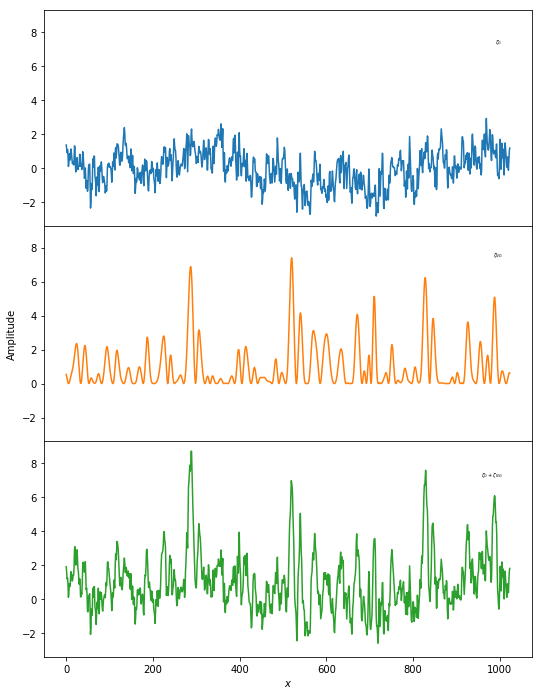

In [19]:
"""
Same plots as above
"""
idxg = 0
idxng = 0
zg = zg_ensemble_train[idxg, :]
zng = zng_ensemble_train[idxng, :]

fontsize = 5

fig, ax = plt.subplots(3, 1,  sharex=True, sharey=True, figsize=(8,10))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Amplitude")
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
# Original NG component
ax[0].plot(zg)
ax[1].plot(zng, color='C1')
ax[2].plot(zng + zg, color='C2')
ax[2].xaxis.set_tick_params(labelbottom=True)
plt.xlabel(r'$x$')

fig.tight_layout()
fig.subplots_adjust(hspace=0)

plt.text(0.94, 0.95, r'$\zeta_G$', fontsize=fontsize, horizontalalignment='right')
plt.text(0.94, 0.62, r'$\zeta_{NG}$', fontsize=fontsize, horizontalalignment='right')
plt.text(0.94, 0.28, r'$\zeta_G + \zeta_{NG}$', fontsize=fontsize, horizontalalignment='right')

# if correlated:
#     plt.savefig('ICA_corr_sources.png')
# else:
#     plt.savefig('ICA_uncorr_sources.png')

# RICA

In [31]:
import numpy as np
import torch
from torch.nn import Parameter
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import TensorDataset, DataLoader
import itertools

In [32]:
"""
Reproduces Reconstruction ICA with PyTorch

1. Modify `torchvision_path_cifar10` to your cifar10 path, or just any folder (it will download dataset automatically)
2. If you do not have a GPU, set `use_gpu=False`. It's going to take more than a few minutes.. If you want to speed
   things up a bit:
   - change lambdas to just [2.4], this runs the script with a single lambda value only, and gives decent result
   - maybe reduce num_epochs to 100
   - if you want to run all the lambda values
     - reduce patch_size to 8, which is probably 2x faster than 16
     - reduce num_epochs to 40
"""

'''
STEP 1: LOADING DATASET
'''
# # use cifar10 as dataset
# dataset = torchvision.datasets.CIFAR10(
#         torchvision_path_cifar10, 
#         train=True, 
#         transform=transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.469, 0.481, 0.451], std=[0.239,0.245,0.272])
#             # normalize to 0-mean, unit-variance
#         ]), 
#         download=True)
#
#
# z_chisq_npy = np.load("../rica/pnong/np-1d_zeta_fields/z_chisq_seeds741785_501982.npy")
# z_chisq = torch.Tensor(z_chisq_npy)
# dataset = TensorDataset(z_chisq) # create your datset
# loader = DataLoader(dataset) # create your dataloader

train_array = np.load("../rica/pnong/1d_z_ensemble-datasets/1d_z_chisq-train-n{n}m{m}.npy".format(n=N_ensemble, m=N_field))
test_array = np.load("../rica/pnong/1d_z_ensemble-datasets/1d_z_chisq-test-n{n}m{m}.npy".format(n=N_ensemble, m=N_field))

train_tensor = torch.Tensor(train_array)
test_tensor = torch.Tensor(test_array)

train_dataset = TensorDataset(train_tensor) # create your datset
test_dataset = TensorDataset(test_tensor) # create your datset


train_size = train_tensor.shape[0]
test_size = test_tensor.shape[0]
nsamples_train = train_tensor.shape[1]
nsamples_test = test_tensor.shape[1]

print(train_size)
print(test_size)
print(nsamples_train)
print(nsamples_test)

5
5
1024
1024


In [33]:
'''
STEP 2: MAKING DATASET ITERABLE
'''

use_gpu    = False              # if to use GPU
def maybe_gpu(data):
    return data.cuda() if use_gpu else data

    
batch_size = 5
num_batches = train_size / batch_size
print(num_batches)

num_steps  = 20            # how many lambdas to try
n_iters = 100              # Any diff between num iterations and num steps in this context?

num_epochs = int(n_iters / num_batches) # how long each lambda runs, 200 is probably overkill
print(num_epochs)

lambdas = [l*0.4 for l in range(1,num_steps)] # the lambda values will be tried one by one

num_features = 2


train_loader = DataLoader(dataset=train_dataset, 
                            batch_size=batch_size, 
                            shuffle=True,
                            pin_memory=True)

test_loader = DataLoader(dataset=test_dataset, 
                            batch_size=batch_size, 
                            shuffle=False,
                            pin_memory=True)


# patch_size = 16                 # patch size to extract, 16 is max
# weight_size= patch_size**2      # weight size is number of pixels in a patch (do not change)
# num_filters = weight_size       # complete-ICA has same number of filters as there are pixels

# torchvision_path_cifar10 = '/Users/JawanHaider/Desktop/research/research_projects/pnong_ml/rica/torchvision_cifar10'

# loader = torch.utils.data.DataLoader(dataset, batch_size=1000, num_workers=2, pin_memory=True)
# # load the entire dataset into a single Tensor, this speeds things up quite a bit
# data_all = []
# for pos in loader:
#     data_all.append(pos)
# data_all = torch.cat(data_all)      # merge into single tensor
# data_all = z_chisq
# data_all = data_all.mean(0)         # make black-white
# print(data_all)
# data_all = maybe_gpu(data_all)

1.0
100


In [ ]:
def doit(lambd=1, epochs=num_epochs):
    weight    = Parameter(maybe_gpu(1.0/patch_size*torch.Tensor(weight_size,num_features).normal_()))
    optimizer = torch.optim.RMSprop([weight], 0.001, momentum=0.9)

    for epoch in range(epochs):
        for batch in range(train_dataset.size(0)/1000):
            # select batch
            imgs = train_dataset[batch*1000:(batch+1)*1000]
            # capture a few patches
            patches = []
            for x,y in itertools.product([0, 8, 16],[0,8,16]):
                patches.append(imgs[:, y:y+patch_size, x:x+patch_size])
            patches = Variable(maybe_gpu(torch.cat(patches)))
            patches = patches.view(patches.size(0), -1)
            latents= patches.matmul(weight)
            output = latents.matmul(weight.t())
            diff = output - patches
            loss_recon = (diff * diff).mean()
            loss_latent= latents.abs().mean()
            loss = lambd * loss_recon + loss_latent
            # optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(epoch, loss.data[0], loss_recon.data[0], loss_latent.data[0])
    weight_images = weight.data.t().contiguous().view(num_features, 1, patch_size, patch_size).cpu()
    vutils.save_image(weight_images, 'rica_weight_images_{}.jpg'.format(lambd), nrow=patch_size, normalize=True)
    print('Finished lambda={}'.format(lambd))


for l in lambdas:
    doit(l)

